In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 

df=pd.read_csv("SalesDataConsolidated - PET Preforms.csv", header=0)
# df=pd.DataFrame(df)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        4782 non-null   object 
 1   PARTY NAME  4782 non-null   object 
 2   TYPE        4782 non-null   object 
 3   GM          4782 non-null   float64
 4   NECK        4782 non-null   object 
 5   Quantity    4780 non-null   object 
dtypes: float64(1), object(5)
memory usage: 224.3+ KB


In [7]:
print(df['GM'].unique())
print(df['NECK'].unique())

[ 9.2  13.6  18.5  32.   34.   18.6   8.9  12.6   9.6   8.6   8.45 18.2
 22.   80.    9.8  10.   12.8  17.8   8.7  19.5 ]
['ALASKA' 'PCO']


In [8]:
#Convert the dataset to correct format and remove the unwanted data
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['GM'] = pd.to_numeric(df['GM'], errors='coerce')
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
df.head()

,DATE,PARTY NAME,TYPE,GM,NECK,Quantity
0,2019-06-24,M P AQUATECH,PET PREFORM,9.2,ALASKA,54.0
1,2019-06-24,M P AQUATECH,PET PREFORM,13.6,ALASKA,220.0
2,2019-06-24,M P AQUATECH,PET PREFORM,9.2,ALASKA,360.0
3,2019-06-24,M P AQUATECH,PET PREFORM,13.6,ALASKA,40.0
4,2019-06-24,M P AQUATECH,PET PREFORM,18.5,ALASKA,18.0


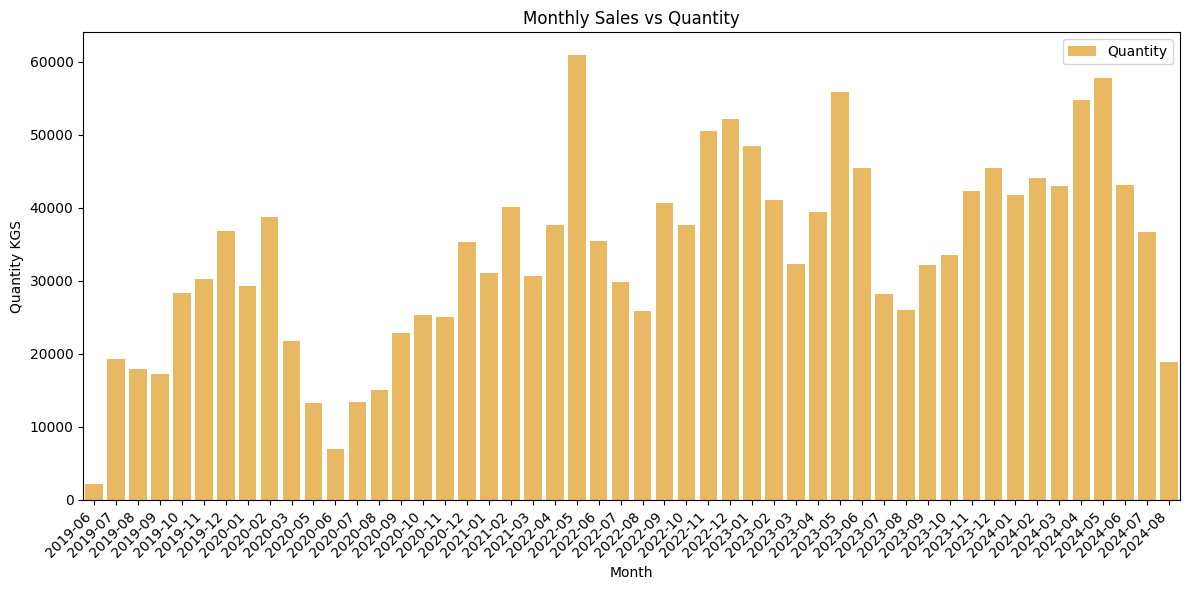

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype    
---  ------    --------------  -----    
 0   DATE      50 non-null     period[M]
 1   TYPE      50 non-null     object   
 2   Quantity  50 non-null     float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 1.3+ KB


In [9]:
#grouping the data monthly
monthly_grp = df.groupby([df['DATE'].dt.to_period('M'),'TYPE']).agg({'Quantity': 'sum'}).reset_index()
#create a new column for month
plt.figure(figsize=(12, 6))
sns.barplot(x='DATE', y='Quantity', data=monthly_grp, color='orange', alpha=0.7, label='Quantity')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Quantity KGS')
plt.title('Monthly Sales vs Quantity')
plt.legend()
plt.tight_layout()
plt.show()
monthly_grp.info()

# Conclusion from this graphical analysis


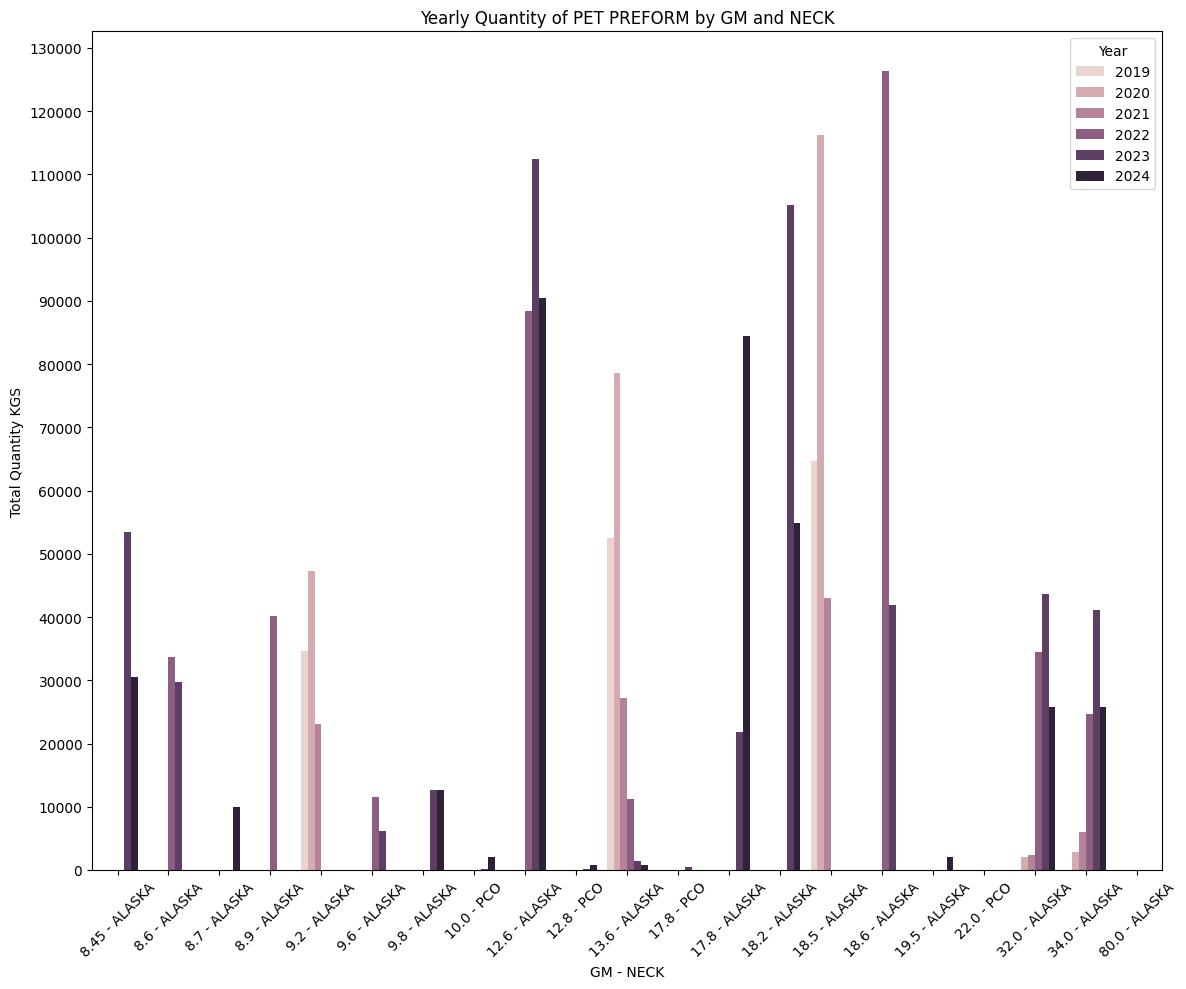

In [10]:
#grouping the data yearly
df['Year'] = df['DATE'].dt.year
yearly_grp = df.groupby(['Year','GM','NECK'])['Quantity'].sum().reset_index()
yearly_grp['GM_NECK'] = yearly_grp['GM'].astype(str) + ' - ' + yearly_grp['NECK']
yearly_grp = yearly_grp.sort_values(by='GM')

plt.figure(figsize=(12, 10))
sns.barplot(x='GM_NECK', y='Quantity', hue='Year', data=yearly_grp)
plt.xlabel('GM - NECK')
plt.ylabel('Total Quantity KGS')
plt.title('Yearly Quantity of PET PREFORM by GM and NECK')
plt.xticks(rotation=45)
y_ticks = np.arange(0, yearly_grp['Quantity'].max() + 10000, 10000) 
plt.yticks(y_ticks)
plt.tight_layout()
plt.show()

# Conclusion from this graphical analysis


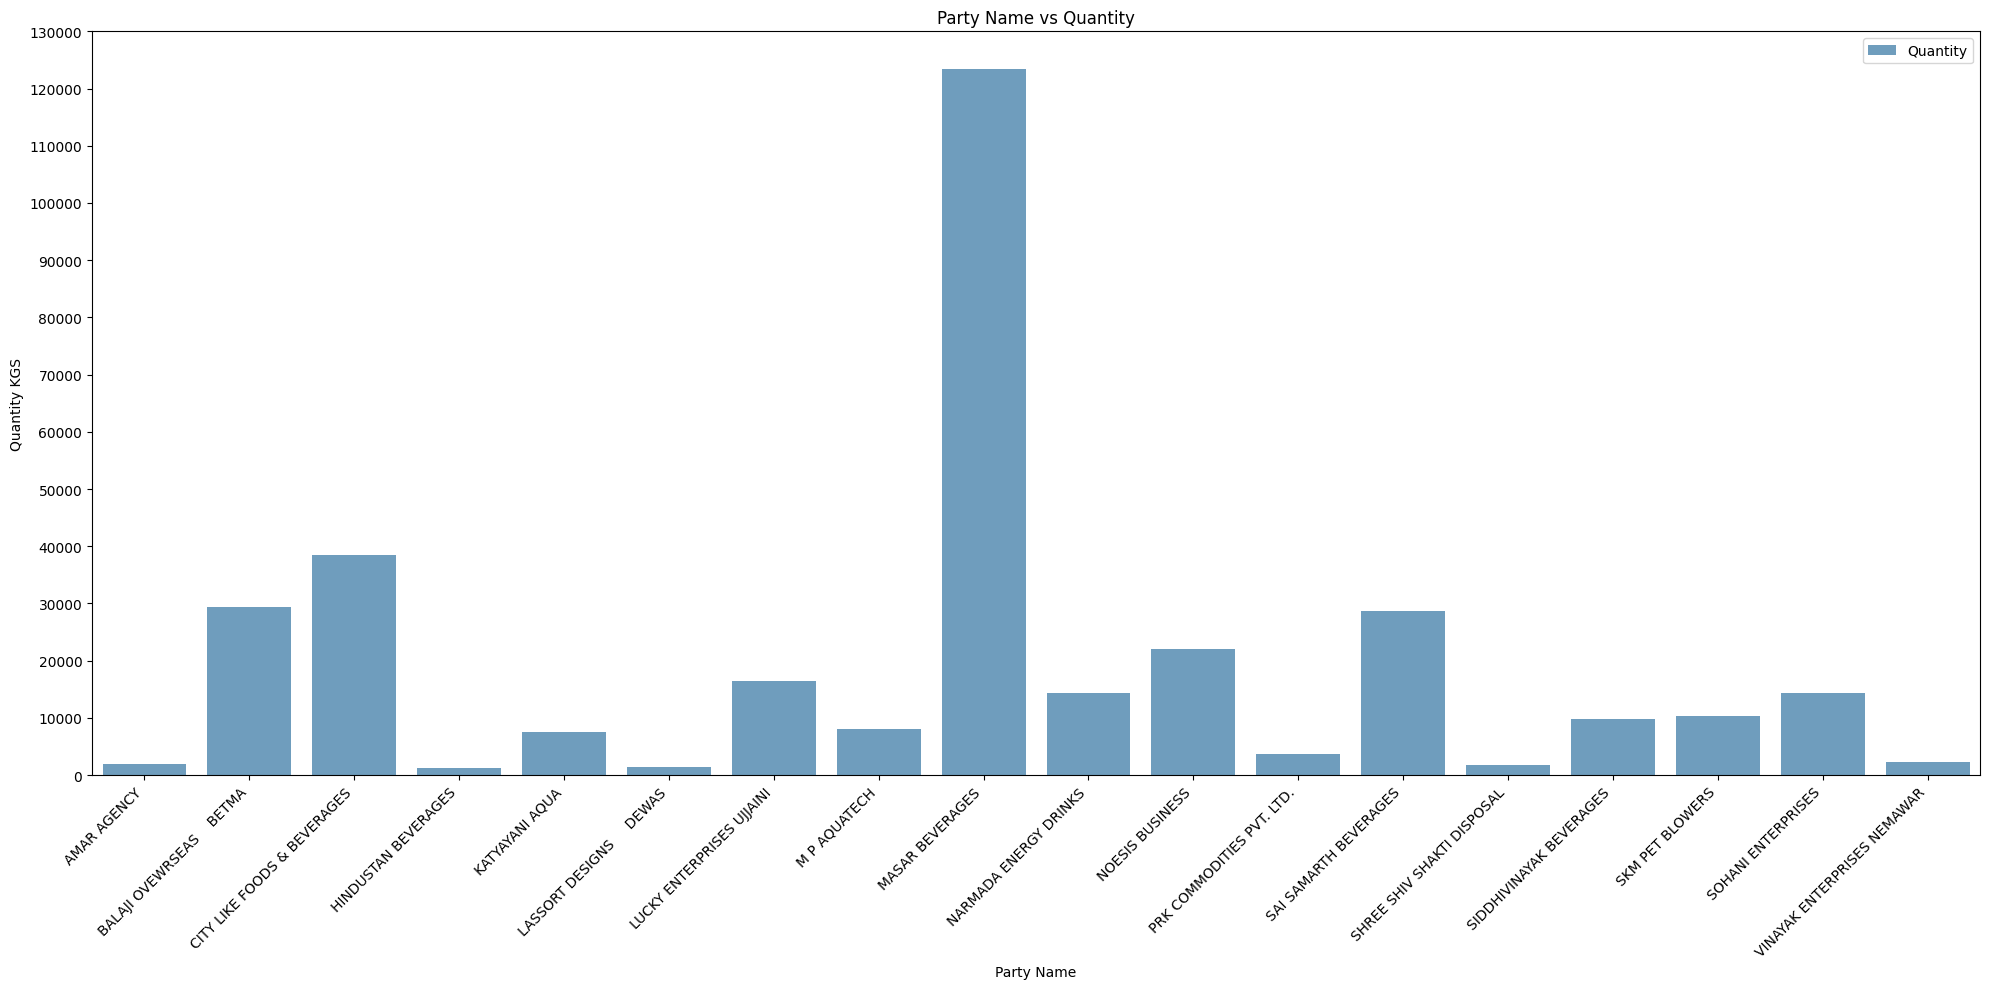

In [11]:
selected_year = 2024
party_grp = df[df['Year'] == selected_year].groupby(['PARTY NAME'])['Quantity'].sum().reset_index()
party_grp = party_grp[party_grp['Quantity'] > 1000]

plt.figure(figsize=(20, 10))
sns.barplot(x='PARTY NAME', y='Quantity', data=party_grp, alpha=0.7, label='Quantity')
plt.xticks(rotation=45, ha='right')
y_ticks = np.arange(0, yearly_grp['Quantity'].max() + 10000, 10000) 
plt.yticks(y_ticks)
plt.xlabel('Party Name')
plt.ylabel('Quantity KGS')
plt.title('Party Name vs Quantity')
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion from this graphical analysis


# **Linear Regression**

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = monthly_grp['DATE'].apply(lambda x: x.to_timestamp().timestamp()).values.reshape(-1, 1)
y = monthly_grp['Quantity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
print("MAE for linear regression: ",mean_absolute_error(y_test,y_pred_lr))


MAE for linear regression:  9579.643868482617


# **Polynomial Regression**

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Apply polynomial features of degree 2 (can experiment with degree)
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
polynomial_model.fit(X_train, y_train)
y_pred_poly = polynomial_model.predict(X_test)

print("MAE for polynomial regression: ",mean_absolute_error(y_test, y_pred_poly))

MAE for polynomial regression:  9829.740507797722


In [14]:
# Add new features to the data
monthly_grp['Year'] = monthly_grp['DATE'].apply(lambda x: x.year)
monthly_grp['Month'] = monthly_grp['DATE'].apply(lambda x: x.month)
monthly_grp['Quarter'] = monthly_grp['DATE'].apply(lambda x: x.quarter)

# **Random Forest Regressor**

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = monthly_grp[['Year', 'Month', 'Quarter']].values
y = monthly_grp['Quantity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

y_pred_rf = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", mae)
print("OOB Score:", regressor.oob_score_)

Mean Absolute Error: 6759.43411764706
OOB Score: 0.774923221831147


In [16]:
#new dataframe with grouping based on date, gm, neck
grouped_df = df.groupby(['DATE', 'TYPE','GM', 'NECK']).agg({'Quantity': 'sum'}).reset_index()
print(grouped_df)

           DATE         TYPE    GM    NECK  Quantity
0    2019-06-24  PET PREFORM   9.2  ALASKA     414.0
1    2019-06-24  PET PREFORM  13.6  ALASKA     260.0
2    2019-06-24  PET PREFORM  18.5  ALASKA      18.0
3    2019-06-26  PET PREFORM   9.2  ALASKA     216.0
4    2019-06-26  PET PREFORM  13.6  ALASKA     108.0
...         ...          ...   ...     ...       ...
3186 2024-08-24  PET PREFORM  34.0  ALASKA     600.0
3187 2024-08-26  PET PREFORM  18.2  ALASKA     200.0
3188 2024-08-26  PET PREFORM  32.0  ALASKA     100.0
3189 2024-08-27  PET PREFORM  12.6  ALASKA     325.0
3190 2024-08-27  PET PREFORM  19.5  ALASKA     250.0

[3191 rows x 5 columns]


# **ARIMA**

In [17]:
ARIMA_df = df.groupby('DATE').agg({'Quantity': 'sum'}).reset_index()
ARIMA_df.set_index('DATE', inplace=True)
print(ARIMA_df.head())

            Quantity
DATE                
2019-06-24     692.0
2019-06-26     540.0
2019-06-28     910.0
2019-07-01      30.0
2019-07-03    2728.0


In [18]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#Check for stationarity
result = adfuller(ARIMA_df['Quantity'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -4.479229315169259
p-value: 0.00021434975665950083


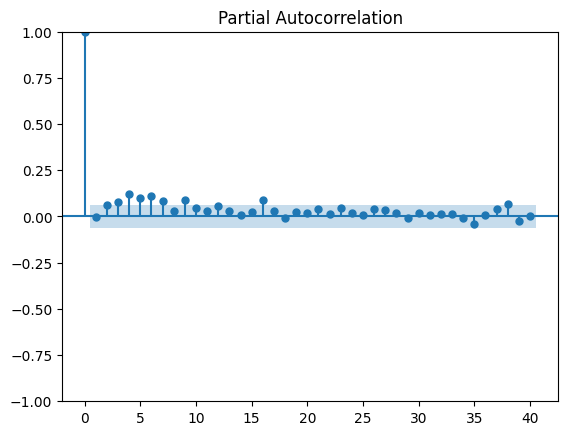

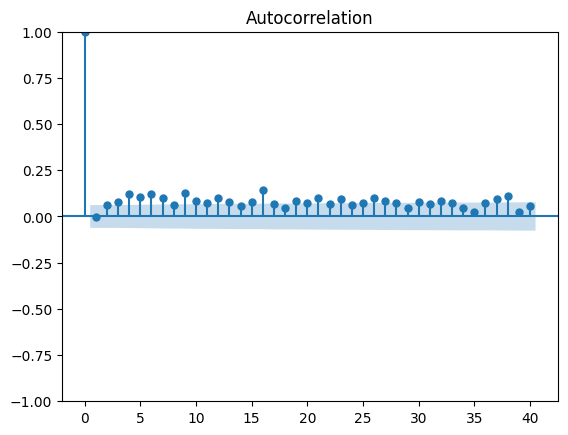

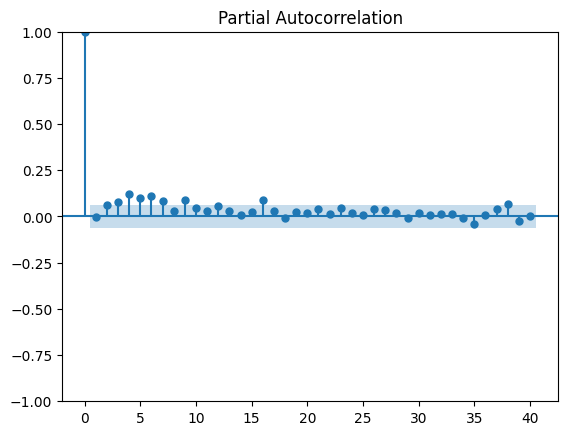

In [19]:
#analysing ACF and PACF plots
plot_acf(ARIMA_df["Quantity"], lags=40)
plot_pacf(ARIMA_df["Quantity"], lags=40)

In [20]:
# Ensure the index is a datetime object
ARIMA_df.index = pd.to_datetime(ARIMA_df.index, errors='coerce')

# Define trainARIMA-test split
train_ARIMA_size = int(len(ARIMA_df) * 0.8)
trainARIMA, testARIMA = ARIMA_df[:train_ARIMA_size], ARIMA_df[train_ARIMA_size:]

# Fit ARIMA model (with p=1, d=0, q=1 initially, since d=0 implies no differencing)
ARIMA = ARIMA(trainARIMA, order=(1, 1, 1))
arima_result = ARIMA.fit()

# Print the summary of the ARIMA model fit
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  802
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6802.727
Date:                Tue, 22 Oct 2024   AIC                          13611.453
Time:                        01:21:43   BIC                          13625.511
Sample:                             0   HQIC                         13616.853
                                - 802                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1180      0.029     -4.110      0.000      -0.174      -0.062
ma.L1         -0.9491      0.011    -89.258      0.000      -0.970      -0.928
sigma2      1.391e+06   4.36e+04     31.863      0.0

/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# Forecast the length of the test set
forecastARIMA = arima_result.forecast(steps=len(testARIMA))
print(forecastARIMA)


802     2160.827803
803     1997.261647
804     2016.566995
805     2014.288428
806     2014.557362
           ...     
998     2014.528971
999     2014.528971
1000    2014.528971
1001    2014.528971
1002    2014.528971
Name: predicted_mean, Length: 201, dtype: float64


/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


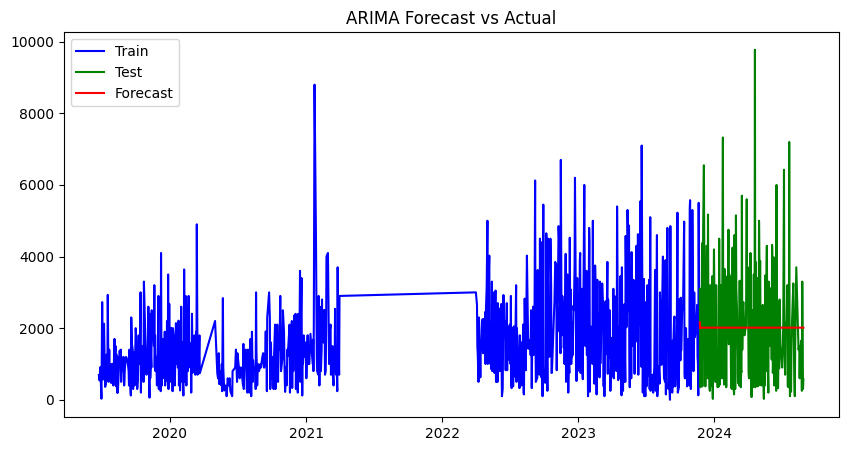

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(ARIMA_df.index[:train_ARIMA_size], trainARIMA, label='Train', color='blue')
plt.plot(ARIMA_df.index[train_ARIMA_size:], testARIMA, label='Test', color='green')
plt.plot(ARIMA_df.index[train_ARIMA_size:], forecastARIMA, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
# Evaluate model performance on the test set
rmse = mean_squared_error(testARIMA["Quantity"], forecastARIMA, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1658.4999292657083


/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
df.head()

,DATE,PARTY NAME,TYPE,GM,NECK,Quantity,Year
0,2019-06-24,M P AQUATECH,PET PREFORM,9.2,ALASKA,54.0,2019
1,2019-06-24,M P AQUATECH,PET PREFORM,13.6,ALASKA,220.0,2019
2,2019-06-24,M P AQUATECH,PET PREFORM,9.2,ALASKA,360.0,2019
3,2019-06-24,M P AQUATECH,PET PREFORM,13.6,ALASKA,40.0,2019
4,2019-06-24,M P AQUATECH,PET PREFORM,18.5,ALASKA,18.0,2019


# **SARIMA**

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_absolute_error, mean_squared_error
SARIMA_df=df[['DATE','Quantity']]
SARIMA_df=df.groupby('DATE').agg({'Quantity': 'sum'}).reset_index()
SARIMA_df = SARIMA_df[SARIMA_df['DATE'] >= '2022-01-01']
SARIMA_df=pd.DataFrame(SARIMA_df)
print(SARIMA_df)


           DATE  Quantity
398  2022-04-01    3000.0
399  2022-04-04    2650.0
400  2022-04-05    1475.0
401  2022-04-06    1300.0
402  2022-04-08     500.0
...         ...       ...
998  2024-08-22    1200.0
999  2024-08-23     250.0
1000 2024-08-24    3300.0
1001 2024-08-26     300.0
1002 2024-08-27     575.0

[605 rows x 2 columns]


In [26]:
SARIMA_df = SARIMA_df.set_index('DATE') 
  
SARIMAmonthly_sales = SARIMA_df.resample('ME').sum()
SARIMAmonthly_sales.head()

,Quantity
DATE,
2022-04-30,37650.0
2022-05-31,60950.0
2022-06-30,35375.0
2022-07-31,29825.0
2022-08-31,25850.0


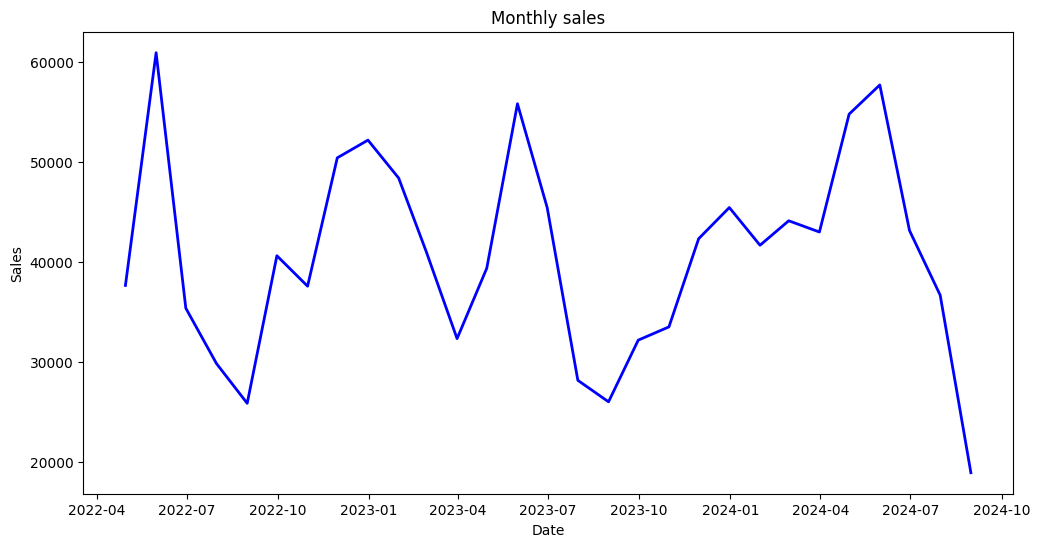

In [27]:
plt.figure(figsize=(12, 6)) 
plt.plot(SARIMAmonthly_sales['Quantity'], linewidth=2,c='blue') 
plt.title("Monthly sales") 
plt.xlabel("Date") 
plt.ylabel("Sales") 
plt.show()

<Figure size 1200x800 with 0 Axes>

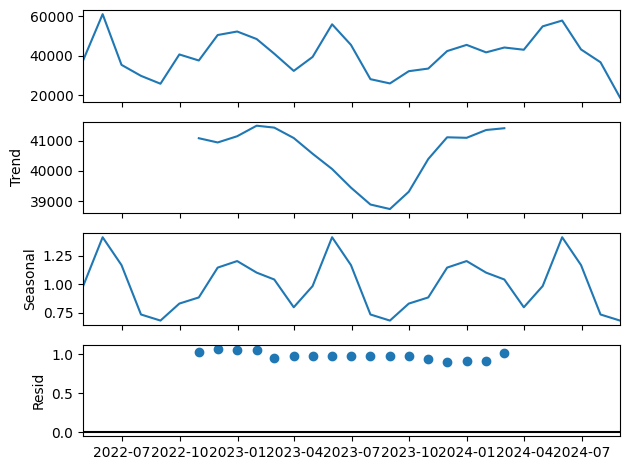

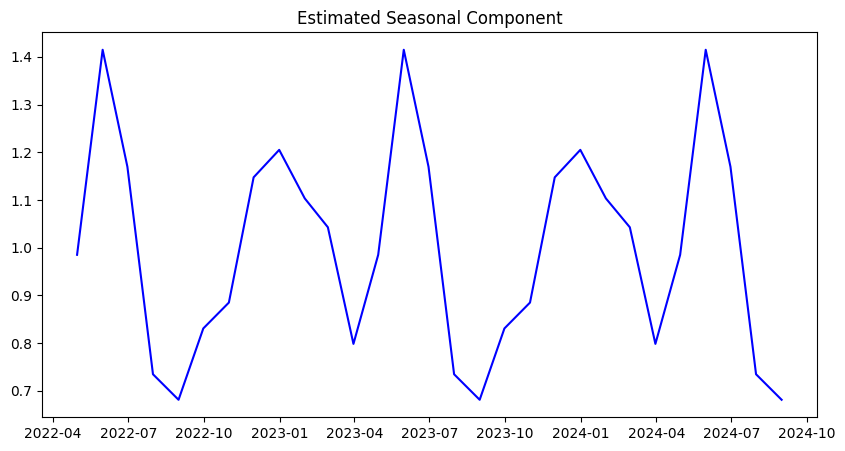

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform decomposition 
decomposition = seasonal_decompose(SARIMAmonthly_sales, model='multiplicative', period=12)  # 12 for monthly seasonality

# Plot the decomposed components
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

# If you want to focus only on the seasonal component:
plt.figure(figsize=(10, 5))
plt.plot(decomposition.seasonal, color='blue')
plt.title('Estimated Seasonal Component')
plt.show()

In [29]:
def check_stationarity(timeseries): 
	# Perform the Dickey-Fuller test 
	result = adfuller(timeseries, autolag='AIC') 
	p_value = result[1] 
	print(f'ADF Statistic: {result[0]}') 
	print(f'p-value: {p_value}') 
	print('Stationary' if p_value < 0.05 else 'Non-Stationary') 


check_stationarity(SARIMAmonthly_sales['Quantity'])


ADF Statistic: -3.547180236485985
p-value: 0.006854928570132168
Stationary


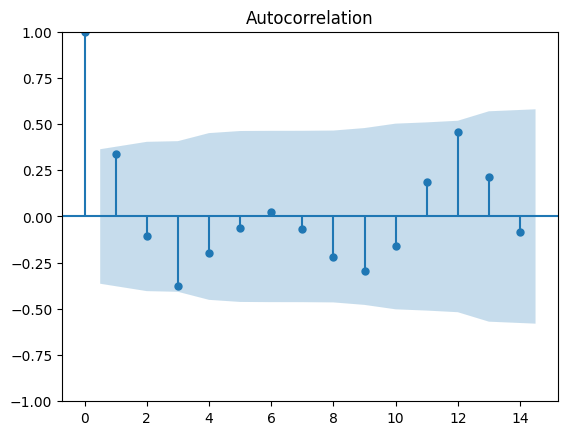

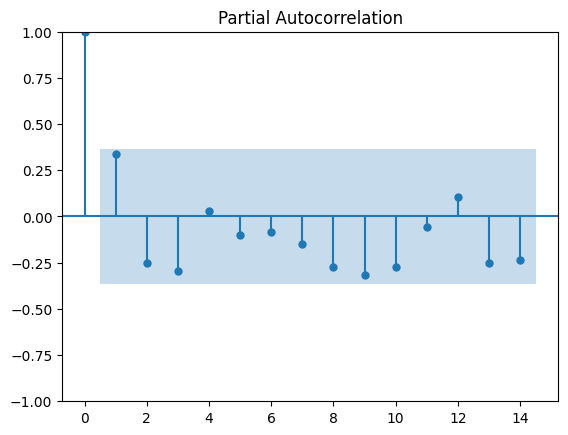

In [30]:
plot_acf(SARIMAmonthly_sales) 
plot_pacf(SARIMAmonthly_sales) 
plt.show()

In [31]:
# Define SARIMA parameters 
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality 
  
# Fit the SARIMA model 
SARIMA = SARIMAX(SARIMAmonthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
SARIMA_result = SARIMA.fit() 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80009D+00    |proj g|=  6.09610D-01

At iterate    5    f=  5.67568D+00    |proj g|=  6.39132D-02

At iterate   10    f=  5.66274D+00    |proj g|=  5.53680D-03

At iterate   15    f=  5.66257D+00    |proj g|=  2.54102D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   2.541D-05   5.663D+00
  F =   5.6625659160517214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


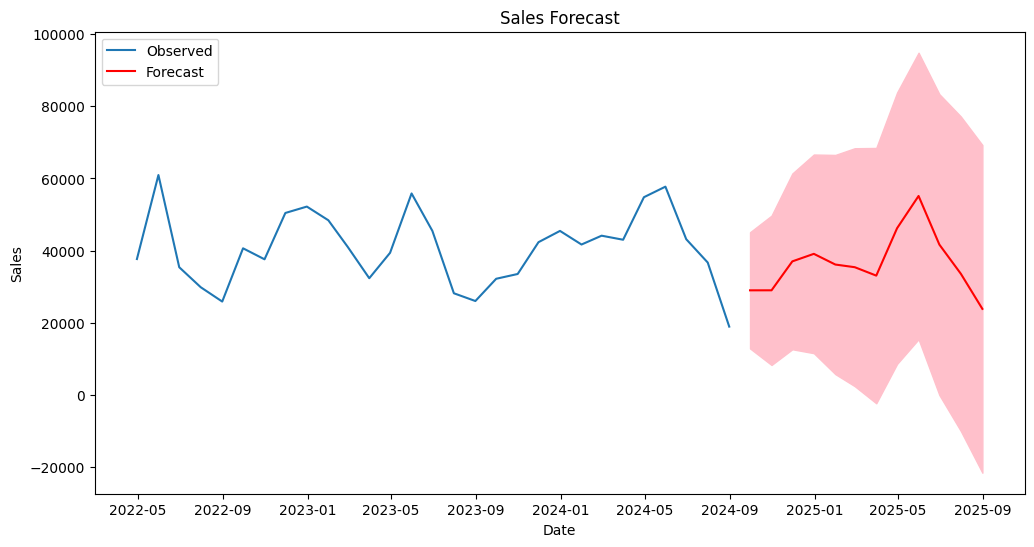

In [32]:
# Forecast future values 
forecast_periods = 12  # Forecast the next 12 months 
forecastSARIMA = SARIMA_result.get_forecast(steps=forecast_periods) 
forecastSARIMA_mean = forecastSARIMA.predicted_mean 
forecastSARIMA_ci = forecastSARIMA.conf_int() 
  
# Plot the forecast 
plt.figure(figsize=(12, 6)) 
plt.plot(SARIMAmonthly_sales, label='Observed') 
plt.plot(forecastSARIMA_mean, label='Forecast', color='red') 
plt.fill_between(forecastSARIMA_ci.index, forecastSARIMA_ci.iloc[:, 0], forecastSARIMA_ci.iloc[:, 1], color='pink') 
plt.title("Sales Forecast") 
plt.xlabel("Date") 
plt.ylabel("Sales") 
plt.legend() 
plt.show()

In [34]:
observed = SARIMAmonthly_sales[-forecast_periods:] 
mae = mean_absolute_error(observed, forecastSARIMA_mean) 
rmse = mean_squared_error(observed, forecastSARIMA_mean, squared=False)
print(f'MAE: {mae}') 
print(f'RMSE: {rmse}')

MAE: 5366.958145965878
RMSE: 5936.510363364963


/Users/rachit/dev/astrPredictionModel/astrvenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
